<a href="https://colab.research.google.com/github/hchristiaan/TrainCNN4SignatureVerification/blob/master/ProjectCode_Transfer_0_seed123.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Please note that:
#     # - Means comment explaining the code
#     ### - Means things that need to be addressed

In [1]:
# Henri code

from google.colab import auth
auth.authenticate_user()

import requests
gcloud_token = !gcloud auth print-access-token
gcloud_tokeninfo = requests.get('https://www.googleapis.com/oauth2/v3/tokeninfo?access_token=' + gcloud_token[0]).json()
email = gcloud_tokeninfo['email']
username = email.split('@')[0]
print(username)

ccar788


In [2]:
# Import all required repositories for the project
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

import keras
import keras.backend as K
import tensorflow as tf
from keras import applications
from keras.models import Model
from keras.layers import Flatten, Dense, Input,concatenate
from keras.optimizers import Adam
from keras.models import load_model, model_from_json

import random

Using TensorFlow backend.


In [3]:
# Import the google drive to upload the data
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
# Unzip the image dataset
!unzip '/content/drive/Team Drives/inputdataset/UTSig.zip' -d /content

Archive:  /content/drive/Team Drives/inputdataset/UTSig.zip
   creating: /content/UTSig/Forgery/
   creating: /content/UTSig/Forgery/Opposite Hand/
   creating: /content/UTSig/Forgery/Opposite Hand/1/
  inflating: /content/UTSig/Forgery/Opposite Hand/1/1.tif  
  inflating: /content/UTSig/Forgery/Opposite Hand/1/2.tif  
  inflating: /content/UTSig/Forgery/Opposite Hand/1/3.tif  
   creating: /content/UTSig/Forgery/Opposite Hand/10/
  inflating: /content/UTSig/Forgery/Opposite Hand/10/1.tif  
  inflating: /content/UTSig/Forgery/Opposite Hand/10/2.tif  
  inflating: /content/UTSig/Forgery/Opposite Hand/10/3.tif  
   creating: /content/UTSig/Forgery/Opposite Hand/100/
  inflating: /content/UTSig/Forgery/Opposite Hand/100/1.tif  
  inflating: /content/UTSig/Forgery/Opposite Hand/100/2.tif  
  inflating: /content/UTSig/Forgery/Opposite Hand/100/3.tif  
   creating: /content/UTSig/Forgery/Opposite Hand/101/
  inflating: /content/UTSig/Forgery/Opposite Hand/101/1.tif  
  inflating: /content/UT

In [0]:
# Proposed file restructing to fit this code
import os, shutil

filePath = '/content/UTSig'

filePathGen = filePath + '/Genuine'
filePathFor = filePath + '/Forgery'
filePathForSk = filePath + '/Forgery/Skilled' 
filePathForOh = filePath + '/Forgery/Opposite Hand' 
filePathForSi = filePath + '/Forgery/Simple' 

if "Simple" in os.listdir(filePathFor):
  if "1" in os.listdir(filePathGen):
      for i in os.listdir(filePathGen):
          author = i
          for j in os.listdir(filePathGen + '/' + author):
              os.rename(filePathGen + '/' + author + "/" + j, filePathGen + "/" + "g_" + author + "_" + j)
          os.removedirs(filePathGen + "/" + author)

  if "Skilled" in os.listdir(filePathFor):
      for i in os.listdir(filePathForSk):
          author = i
          for j in os.listdir(filePathForSk + '/' + author):
              os.rename(filePathForSk + '/' + author + "/" + j, filePathFor + "/" + "fSk_" + author + "_" + j)
          os.removedirs(filePathForSk + "/" + author)

  if "Opposite Hand" in os.listdir(filePathFor):
      for i in os.listdir(filePathForOh):
          author = i
          for j in os.listdir(filePathForOh + '/' + author):
              os.rename(filePathForOh + '/' + author + "/" + j, filePathFor + "/" + "fOh_" + author + "_" + j)
          os.removedirs(filePathForOh + "/" + author)

  if "Simple" in os.listdir(filePathFor):
    for i in os.listdir(filePathForSi):
        author = i
        count = 1
        for j in os.listdir(filePathForSi + '/' + author):
            os.rename(filePathForSi + '/' + author + "/" + j, filePathFor + "/" + "fSi_" + author + "_" + str(count) + ".tif")
            count = count + 1
        os.removedirs(filePathForSi + "/" + author)

In [0]:
### Need code for altering .tif files into .png? or can we go ahead and just work with .tif? ###

In [0]:
# File paths of the image data used later in the project
### Need to discuss how we will seperate our data. 80% 20% rule? ###
gentr="/content/UTSig/Genuine"
forgtr="/content/UTSig/Forgery"

gent="/content/UTSig/Genuine"
forgt="/content/UTSig/Forgery"

In [0]:
random.seed(123)

sigIndex = list(range(1,116))
random.shuffle(sigIndex)

folds = [sigIndex[0:30],sigIndex[30:60],sigIndex[60:90]]
test =sigIndex[90:116]
train1 = list(set(folds[0]+folds[1]))
train2 = list(set(folds[1]+folds[2]))
train3 = list(set(folds[0]+folds[2]))
train = [train1,train2,train3]
valid = [folds[2],folds[0], folds[1]]

In [0]:
# Code block for working with the image files (resizing, retreiving files, etc.)

# Standard height weight for images
img_width, img_height, channels = 224, 224, 3

dim = (img_width, img_height)

# Converts the images to rgb which is what VGG-16 takes as input
def to_rgb(img):
    img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA) 
    img_rgb = np.asarray(np.dstack((img, img, img)), dtype=np.uint8)
    return img_rgb


# Takes in file path and image name and returns resized image
def returnimages(path,img):
    image=cv2.imread(path+"/"+ img)                  #bringing the image
    image=cv2.resize(image, (img_width, img_height))
    image=cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image=to_rgb(image).reshape(1,img_width, img_height,3)/255.0       #resizing and normalizing    
    return image     

# Takes in number of author, path for genuine and forged signatures
# Returns one image name (m.pop()), and two arrays of file names n = forgary, m = genuine
# Used for generator()
def getfiles(num,gen,forg):
    genList=os.listdir(gen)
    forgList=os.listdir(forg)
    author=str(num)
           
    forgArr,genArr=[],[]
    for i in forgList:
        if ("_" + author + "_") in i:
            forgArr = forgArr + [i]
            
    for i in genList:
        if ("_" + author + "_") in i:
            genArr = genArr + [i]
     
    return genArr.pop(), forgArr, genArr
######################################

# Same as getfiles but returns two files
def getfilest(num,gen,forg):
    genList=os.listdir(gen)
    forgList=os.listdir(forg)
    author=str(num)
           
    forgArr,genArr=[],[]
    for i in forgList:
        if ("_" + author + "_") in i:
            forgArr = forgArr + [i]
            
    for i in genList:
        if ("_" + author + "_") in i:
            genArr = genArr + [i]

    return genArr.pop(), genArr.pop(), forgArr, genArr

In [0]:
# Function for defining loss variable in model, leave for now, look into altering?
### Unsure what y_pred is doing, or how this works....
def triplet_loss(y_true, y_pred):
    alpha = 0.5
    anchor, positive, negative =y_pred[0,0:512], y_pred[0,512:1024], y_pred[0,1024:1536]
    
    positive_distance = K.mean(K.square(anchor - positive),axis=-1)
    negative_distance = K.mean(K.square(anchor - negative),axis=-1)
    return K.mean(K.maximum(0.0, positive_distance - negative_distance + alpha))

In [10]:
# Defining the architecture. Three as we are doing 3 fold cross validation
model1 = applications.vgg16.VGG16(weights='imagenet', include_top=False, pooling='max')
model2 = applications.vgg16.VGG16(weights='imagenet', include_top=False, pooling='max')
model3 = applications.vgg16.VGG16(weights='imagenet', include_top=False, pooling='max')



Instructions for updating:
Colocations handled automatically by placer.
58892288/58889256 [==============================] - 4s 0us/step


In [0]:
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [0]:
# For layers from 1 to 15 freeze the weights

### We will need to do a test for each layer to find the optimal transfer* ###
### For now just copying over the code from example
#for layer in model1.layers[:4]:
#    layer.trainable = False
    
#for layer in model2.layers[:4]:
#    layer.trainable = False
    
#for layer in model3.layers[:4]:
    #print(layer)
#    layer.trainable = False

In [0]:
# all "in" variables are defining the input "shape" for the model
# Input is a function in Keras
# Positive represents genuine / Negative represents Forgary 
anchor_in = Input(shape=(img_width, img_height, channels))
pos_in = Input(shape=(img_width, img_height, channels))
neg_in = Input(shape=(img_width, img_height, channels))

# Defining output of model
#for i in range(3):
anchor_out1 = model1(anchor_in)
pos_out1 = model1(pos_in)
neg_out1 = model1(neg_in)
merged_vector1 = concatenate([anchor_out1, pos_out1, neg_out1],axis=1)

anchor_out2 = model2(anchor_in)
pos_out2 = model2(pos_in)
neg_out2 = model2(neg_in)
merged_vector2 = concatenate([anchor_out2, pos_out2, neg_out2],axis=1)

anchor_out3 = model3(anchor_in)
pos_out3 = model3(pos_in)
neg_out3 = model3(neg_in)
merged_vector3 = concatenate([anchor_out3, pos_out3, neg_out3],axis=1)

In [0]:
# Setting inputs and outputs of the model
# Model function - potentially overwrites the input and output layers
### Unsure what the output is... Need to research ###
# Input is 3 images: image in question (anchor), postitive image, negative image (same authors)

model1 = Model(inputs=[anchor_in, pos_in, neg_in], outputs=merged_vector1)
model2 = Model(inputs=[anchor_in, pos_in, neg_in], outputs=merged_vector2)
model3 = Model(inputs=[anchor_in, pos_in, neg_in], outputs=merged_vector3)

In [0]:
# Compiling the model
# loss function set to function defined earlier
# Optimizer is for learning rate of the function
### unsure what Adam function does

model1.compile(optimizer=Adam(lr=0.000005),loss=triplet_loss)
model2.compile(optimizer=Adam(lr=0.000005),loss=triplet_loss)
model3.compile(optimizer=Adam(lr=0.000005),loss=triplet_loss)


In [14]:
import datetime

now = datetime.datetime.now()
date = now.strftime("%Y%m%d%H%M")

print(date)

path = "/content/drive/Team Drives/results/" + username + "/" + date + "/"
os.mkdir(path)

201905190426


In [0]:
# Generator - Goes through every author (in test) and returns an anchor (last image) and an array of file names (negative=forged) (positive=genuine) 
def generator(x):
  #  for i in range(1,96):
    print("Training " + str(x))
    for i in x:
      # Returns last genuine image, array of pos/genuine files, array of neg/forgary files
        anc,neg,pos=getfiles(i,gentr,forgtr)
        
#When we have the list of images/arrays for that author, we then loop through for the length of the negative list (total number of forged)
  #For each negative image, we are going to loop through the length of the positive list
    #For each positive image we resize the anchor, first
    
        for i in range(len(neg)):           
            for j in range(len(pos)):        
                anchor=returnimages(gentr,anc)
                positive=returnimages(gentr,pos[j])
                negative=returnimages(forgtr,neg[i])
               # yield ([anc,pos[j],neg[i]],[0])
                yield ([anchor,positive,negative],[0])

In [0]:
# Generator - Goes through every author (in test) and returns an anchor (last image) and an array of file names (negative=forged) (positive=genuine) 
def generator_validator(x):
    print("Validation " + str(x))
    for i in x:
      # Returns last genuine image, array of pos/genuine files, array of neg/forgary files
        anc,neg,pos=getfiles(i,gentr,forgtr)
        
#When we have the list of images/arrays for that author, we then loop through for the length of the negative list (total number of forged)
  #For each negative image, we are going to loop through the length of the positive list
    #For each positive image we resize the anchor, first
    
        for i in range(len(neg)):           
            for j in range(len(pos)):        
                anchor=returnimages(gentr,anc)
                positive=returnimages(gentr,pos[j])
                negative=returnimages(forgtr,neg[i])
               # yield ([anc,pos[j],neg[i]],[0])
                yield ([anchor,positive,negative],[0])

In [0]:
### These values were taken from example, need to decide on what they should be
logs = ["freeze0training1.log", "freeze0training2.log", "freeze0training3.log"]
weights = ["freeze0_model_weights_1.h5", "freeze0_model_weights_2.h5", "freeze0_model_weights_3.h5"]


In [18]:

print("Starting model: 1")
#for i in range(3):

print("Iteration: 1")
#initial_weights = path + "initial_weights.h5"
  #baseModel.load_weights(initial_weights)
  #baseModel.trainable = True
weight = path + weights[0]
log = path + logs[0]
csv = keras.callbacks.CSVLogger(log)
es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, verbose=1, mode='auto', baseline=.48, restore_best_weights=True)
  #es_list = [es, csv]
cb_list = [es, csv]
#history = baseModel.fit_generator(generator(),steps_per_epoch=200,epochs=10,callbacks= es_list,validation_data=generator_validator(),validation_steps=5)
history = model1.fit_generator(generator(train[0]),steps_per_epoch=200,epochs=90,callbacks = cb_list, validation_data=generator_validator(valid[0]),validation_steps=100)
model1.save_weights(weight)

Starting model: 1
Iteration: 1
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/90
Training [4, 8, 10, 11, 13, 15, 16, 20, 22, 23, 24, 25, 28, 29, 30, 31, 33, 36, 37, 39, 42, 45, 46, 47, 48, 51, 52, 54, 55, 57, 59, 60, 63, 64, 65, 66, 68, 70, 71, 73, 76, 78, 79, 80, 81, 82, 83, 86, 87, 88, 89, 93, 94, 96, 97, 101, 105, 110, 111, 112]
Validation [50, 84, 26, 2, 85, 27, 75, 67, 98, 40, 107, 61, 34, 62, 74, 91, 38, 3, 17, 19, 95, 6, 109, 58, 41, 92, 9, 106, 77, 113]
200/200 [==============================] - 28s 139ms/step - loss: 0.0305 - val_loss: 0.2837
Epoch 2/90
200/200 [==============================] - 22s 109ms/step - loss: 0.0022 - val_loss: 0.1553
Epoch 3/90
200/200 [==============================] - 22s 110ms/step - loss: 0.0014 - val_loss: 0.1650
Epoch 4/90
200/200 [==============================] - 22s 112ms/step - loss: 3.9464e-04 - val_loss: 0.2924
Epoch 5/90
200/200 [======================

0.0


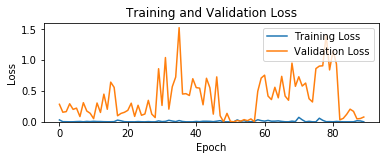

In [19]:
loss = history.history['loss']
val_loss = history.history['val_loss']

print(min(val_loss))

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

In [20]:
print("Starting model: 2")
#for i in range(3):

print("Iteration: 2")
#initial_weights = path + "initial_weights.h5"
  #baseModel.load_weights(initial_weights)
  #baseModel.trainable = True
weight = path + weights[1]
log = path + logs[1]
csv = keras.callbacks.CSVLogger(log)
es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, verbose=1, mode='auto', baseline=.48, restore_best_weights=True)
  #es_list = [es, csv]
cb_list = [es, csv]
#history = baseModel.fit_generator(generator(),steps_per_epoch=200,epochs=10,callbacks= es_list,validation_data=generator_validator(),validation_steps=5)
history = model2.fit_generator(generator(train[1]),steps_per_epoch=200,epochs=90,callbacks = cb_list, validation_data=generator_validator(valid[1]),validation_steps=100)
model2.save_weights(weight)

Starting model: 2
Iteration: 2
Epoch 1/90
Validation [10, 37, 48, 57, 47, 83, 16, 46, 76, 87, 4, 15, 20, 97, 29, 64, 70, 112, 13, 8, 23, 68, 88, 93, 45, 31, 101, 86, 52, 55]Training [2, 3, 6, 9, 11, 17, 19, 22, 24, 25, 26, 27, 28, 30, 33, 34, 36, 38, 39, 40, 41, 42, 50, 51, 54, 58, 59, 60, 61, 62, 63, 65, 66, 67, 71, 73, 74, 75, 77, 78, 79, 80, 81, 82, 84, 85, 89, 91, 92, 94, 95, 96, 98, 105, 106, 107, 109, 110, 111, 113]

200/200 [==============================] - 24s 121ms/step - loss: 0.0227 - val_loss: 0.1543
Epoch 2/90
200/200 [==============================] - 23s 113ms/step - loss: 0.0042 - val_loss: 0.1863
Epoch 3/90
200/200 [==============================] - 22s 112ms/step - loss: 0.0055 - val_loss: 0.1984
Epoch 4/90
200/200 [==============================] - 22s 112ms/step - loss: 0.0000e+00 - val_loss: 0.1002
Epoch 5/90
200/200 [==============================] - 22s 112ms/step - loss: 0.0000e+00 - val_loss: 0.1900
Epoch 6/90
200/200 [==============================] - 22s 112

0.001062912940979004


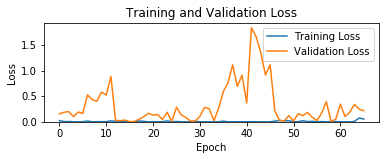

In [21]:
loss2 = history.history['loss']
val_loss2 = history.history['val_loss']

print(min(val_loss2))

plt.subplot(2, 1, 2)
plt.plot(loss2, label='Training Loss')
plt.plot(val_loss2, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

In [22]:
print("Starting model: 3")
#for i in range(3):

print("Iteration: 3")
#initial_weights = path + "initial_weights.h5"
  #baseModel.load_weights(initial_weights)
  #baseModel.trainable = True
weight = path + weights[2]
log = path + logs[2]
csv = keras.callbacks.CSVLogger(log)
es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, verbose=1, mode='auto', baseline=.48, restore_best_weights=True)
  #es_list = [es, csv]
cb_list = [es, csv]
#history = baseModel.fit_generator(generator(),steps_per_epoch=200,epochs=10,callbacks= es_list,validation_data=generator_validator(),validation_steps=5)
history = model3.fit_generator(generator(train[2]),steps_per_epoch=200,epochs=90,callbacks = cb_list, validation_data=generator_validator(valid[2]),validation_steps=100)
model3.save_weights(weight)

Starting model: 3
Iteration: 3
Epoch 1/90
Validation [80, 25, 30, 71, 63, 36, 89, 22, 11, 79, 54, 82, 81, 60, 78, 59, 24, 66, 111, 73, 94, 39, 96, 51, 65, 110, 105, 28, 33, 42]
Training [2, 3, 4, 6, 8, 9, 10, 13, 15, 16, 17, 19, 20, 23, 26, 27, 29, 31, 34, 37, 38, 40, 41, 45, 46, 47, 48, 50, 52, 55, 57, 58, 61, 62, 64, 67, 68, 70, 74, 75, 76, 77, 83, 84, 85, 86, 87, 88, 91, 92, 93, 95, 97, 98, 101, 106, 107, 109, 112, 113]
200/200 [==============================] - 24s 122ms/step - loss: 0.0226 - val_loss: 0.4465
Epoch 2/90
200/200 [==============================] - 22s 112ms/step - loss: 0.0045 - val_loss: 0.3953
Epoch 3/90
200/200 [==============================] - 22s 112ms/step - loss: 0.0065 - val_loss: 0.1860
Epoch 4/90
200/200 [==============================] - 22s 112ms/step - loss: 0.0000e+00 - val_loss: 0.1351
Epoch 5/90
200/200 [==============================] - 22s 112ms/step - loss: 0.0000e+00 - val_loss: 0.2485
Epoch 6/90
200/200 [==============================] - 22s 112

0.001171579360961914


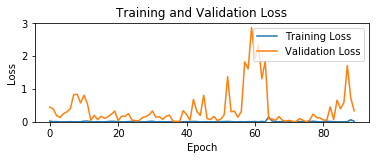

In [23]:
loss3 = history.history['loss']
val_loss3 = history.history['val_loss']

print(min(val_loss3))

plt.subplot(2, 1, 2)
plt.plot(loss3, label='Training Loss')
plt.plot(val_loss3, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

In [24]:
### Unsure purpose of this part ###

# used for validation

tneg,tpos = 0, 0

for k in test: #the id of signatures you want to check
    #print("When k is ", k)
    anc,neg,pos=getfiles(k,gent,forgt)
    tneg=tneg+len(neg)
    tpos=tpos+len(pos)
print("Forgary Image Total: " + str(tneg),"Genuine Image Total: " + str(tpos))

Forgary Image Total: 1125 Genuine Image Total: 650


In [25]:
i = 0
print("Iteration: " + str(i))
weight = path + weights[0]
model1.load_weights(weight)
  
forg_passed=0
gen_flagged=0

for k in test: #the id of signatures you want to check
    print("When k is ", k)
    anc,neg,pos=getfiles(k,gent,forgt)
    
    anchor=returnimages(gent,anc)
    for i in range(len(pos)): #pos
        positive=returnimages(gent,pos[i])
        x=model1.predict([anchor,positive,anchor])
        a, p, useless = x[0,0:512], x[0,512:1024], x[0,1024:1536]
        #dist=sum(a-p)
        dist=np.linalg.norm(a-p)
        #print("positive distance is ",dist)
        if(dist>32):
        #  print("0")
            gen_flagged=gen_flagged+1
            print("gen flagged - ",dist, "file name is - ", pos[i])
            
        else:
            gen_flagged=gen_flagged
        #   print("1")
        
    for j in range(len(neg)): #neg
        negative=returnimages(forgt,neg[j])
        x=model1.predict([anchor,negative,anchor])
        a, n, useless = x[0,0:512], x[0,512:1024], x[0,1024:1536]
        #dist=sum(a-n)
        dist=np.linalg.norm(a-n)
        #print("negative distance is ",dist)
        if(dist>32):
            forg_passed=forg_passed
          #  print("0")
        else:
            forg_passed=forg_passed+1
            print("forg passed - ",dist, "file name is - ", neg[j])
          #  print("1")

print("base_forg_passed is ",forg_passed)
print("base_gen_flagged is ",gen_flagged)
print("False Acceptance Rate (FAR) = ", str(100*forg_passed/tneg), "%")
print("False Rejection Rate (FRR) = ", str(100*gen_flagged/tpos), "%")

Iteration: 0
When k is  56
gen flagged -  33.68869 file name is -  g_56_4.tif
gen flagged -  38.396225 file name is -  g_56_16.tif
gen flagged -  35.947777 file name is -  g_56_2.tif
gen flagged -  47.470444 file name is -  g_56_12.tif
gen flagged -  32.836384 file name is -  g_56_11.tif
gen flagged -  34.403698 file name is -  g_56_9.tif
gen flagged -  35.423824 file name is -  g_56_20.tif
gen flagged -  32.72754 file name is -  g_56_23.tif
forg passed -  24.240166 file name is -  fSi_56_12.tif
forg passed -  27.66028 file name is -  fSi_56_14.tif
forg passed -  30.973225 file name is -  fSi_56_6.tif
forg passed -  30.990824 file name is -  fSi_56_1.tif
forg passed -  29.0659 file name is -  fSi_56_31.tif
forg passed -  28.972664 file name is -  fSk_56_4.tif
forg passed -  29.427853 file name is -  fSk_56_1.tif
forg passed -  29.941639 file name is -  fSi_56_28.tif
forg passed -  27.772516 file name is -  fSi_56_26.tif
forg passed -  30.189995 file name is -  fSi_56_17.tif
forg passed

In [26]:
  i = 0
  print("Iteration: " + str(i))
  weight = path + weights[0]
  model1.load_weights(weight)
  
  forg_passed=0
  gen_flagged=0

  for k in test: #the id of signatures you want to check
    print("When k is ", k)
    anc1,anc2,neg,pos=getfilest(k,gent,forgt)
    
    anchor1=returnimages(gent,anc1)
    anchor2=returnimages(gent,anc2)
    for i in range(len(pos)): #pos
        positive=returnimages(gent,pos[i])
        x=model1.predict([anchor1,positive,anchor2])
        a1, p, a2 = x[0,0:512], x[0,512:1024], x[0,1024:1536]
        #dist=sum(a-p)
        
        #Taking two distances (two anchor images), and taking average between the two
        dist1=np.linalg.norm(a1-p)
        dist2=np.linalg.norm(a2-p)
        dist=(dist1+dist2)/2
        #print("positive distance is ",dist)
        if(dist>32):
        #  print("0")
            gen_flagged=gen_flagged+1
            print("gen flagged - ",dist, "file name is - ", pos[i])
            
        else:
            gen_flagged=gen_flagged
        #   print("1")
        
    for j in range(len(neg)): #neg
        negative=returnimages(forgt,neg[j])
        x=model1.predict([anchor1,negative,anchor2])
        a1, n, a2 = x[0,0:512], x[0,512:1024], x[0,1024:1536]
        #dist=sum(a-n)
        dist1=np.linalg.norm(a1-n)
        dist2=np.linalg.norm(a2-n)
        #print("negative distance is ",dist)
        dist=(dist1+dist2)/2
        if(dist>32):
            forg_passed=forg_passed
          #  print("0")
        else:
            forg_passed=forg_passed+1
            print("forg passed - ",dist, "file name is - ", neg[j])
          #  print("1")

  print("base_forg_passed is ",forg_passed)
  print("base_gen_flagged is ",gen_flagged)
  print("False Acceptance Rate (FAR) = ", str(100*forg_passed/tneg), "%")
  print("False Rejection Rate (FRR) = ", str(100*gen_flagged/tpos), "%")


Iteration: 0
When k is  56
gen flagged -  34.186248779296875 file name is -  g_56_4.tif
gen flagged -  36.069637298583984 file name is -  g_56_16.tif
gen flagged -  34.55946350097656 file name is -  g_56_2.tif
gen flagged -  41.44062805175781 file name is -  g_56_12.tif
gen flagged -  32.03145217895508 file name is -  g_56_20.tif
forg passed -  29.04787826538086 file name is -  fSi_56_12.tif
forg passed -  31.8203125 file name is -  fSi_56_6.tif
forg passed -  31.295719146728516 file name is -  fSi_56_31.tif
forg passed -  30.293743133544922 file name is -  fSk_56_4.tif
forg passed -  29.510730743408203 file name is -  fSi_56_28.tif
forg passed -  30.067760467529297 file name is -  fSi_56_26.tif
forg passed -  31.71077537536621 file name is -  fSi_56_17.tif
forg passed -  26.24830436706543 file name is -  fSi_56_29.tif
forg passed -  27.894529342651367 file name is -  fSk_56_3.tif
forg passed -  27.91761016845703 file name is -  fSk_56_6.tif
forg passed -  31.612367630004883 file name 